In [1]:
import numpy
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.cuda as cuda
import torch
import torchvision


In [2]:
use_gpu = torch.cuda.is_available()

In [51]:
class bottleneck(nn.Module):
    
    def __init__(self, n_channels_in, n_channels, n_channels_out, strides=(1,1), cardinality=1):
        """
        The network is made of multiple residual blocks of similar structure.
        There are many skip connections between these blocks to ease training.
        """
        super().__init__()


        # WHY???
        self.conv1 = nn.Conv2d(in_channels=n_channels_in,
                      out_channels=n_channels, 
                      kernel_size=1, 
                      stride=1, 
                     )
        self.cl1 = self.common_layers(n_channels)
        

        # ResNeXt
        self.gc1 = self.group_conv(n_channels, strides=strides, cardinality=cardinality)
        self.bn1 = nn.BatchNorm2d(n_channels)


        self.conv2 = nn.Conv2d(in_channels=n_channels,
                          out_channels=n_channels_out, 
                          kernel_size=1, 
                          stride=1, 
                         )
        # applying batch norm before adding with the shortcut
        self.bn2 = nn.BatchNorm2d(n_channels_out)

        # if shortcut is between layers with with differnet sizes
        if n_channels_in != n_channels_out or strides != (1,1):
            self.project = nn.Conv2d(n_channels_in, n_channels_out, kernel_size=1, stride=strides)
        else:
            self.project = None

        self.relu = nn.LeakyReLU()
        

    def common_layers(self, n_channels):
        return nn.Sequential(nn.BatchNorm2d(n_channels), nn.LeakyReLU() )

    def group_conv(self, n_channels, strides, cardinality):

        # Cardinality should divide n_channel in order for n_channel(s) to be spilt to #cardinality groups
        assert not n_channels % cardinality 

        # No. of layers in each split
        d = n_channels // cardinality

        # Splitting layers into different groups and convolving. 
        # Principle idea of ResNeXt
        groups = nn.Conv2d(in_channels=n_channels, 
                           out_channels=n_channels, 
                           kernel_size=(3,3), 
                           stride=strides, 
                           groups=cardinality,
                           padding=1,
                           bias=True, 
                          )

        # Concatinating the groups into a single tensor
        

        return groups

    def forward(self, y):
        shortcut = y

        y = self.conv1(y)
        y = self.cl1(y)
        y = self.gc1(y)
        y = self.bn1(y)
        y = self.conv2(y)
        y = self.bn2(y)

        if callable(self.project):
            shortcut = self.project(shortcut)


        y += shortcut

        y = self.relu(y)

        return y





class ResNeXt(nn.Module):    
    cardinality = 1 # if 1 then ResNet
    def __init__(self, cardinality=1):
        super(ResNeXt, self).__init__()
        
         # conv1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # conv2
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)



        # Simple bottleneck with 64-84-100
        
        self.rb = bottleneck(64, 84, 100, cardinality=cardinality)

        self.avg_pool = nn.AvgPool2d(7)
        self.fc = nn.Linear(100, 10)   
        
        
    
    def common_layers(self):
        return nn.Sequential(nn.BatchNorm2d(64), nn.LeakyReLU(y) )

    
    
    def forward(self, x):
        """
        If cardinality=1, then ResNet otherwise know as ResNeXt
        """    
    
    
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        # conv2
        x = self.max_pool(x)



        # Simple bottleneck with 64-84-100
        
        x = self.rb(x)

        x = self.avg_pool(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x
        
        
    
    

In [52]:
net = ResNeXt()
print(net)

ResNeXt(
  (conv1): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (max_pool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (rb): bottleneck(
    (conv1): Conv2d (64, 84, kernel_size=(1, 1), stride=(1, 1))
    (cl1): Sequential(
      (0): BatchNorm2d(84, eps=1e-05, momentum=0.1, affine=True)
      (1): LeakyReLU(0.01)
    )
    (gc1): Conv2d (84, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(84, eps=1e-05, momentum=0.1, affine=True)
    (conv2): Conv2d (84, 100, kernel_size=(1, 1), stride=(1, 1))
    (bn2): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True)
    (project): Conv2d (64, 100, kernel_size=(1, 1), stride=(1, 1))
    (relu): LeakyReLU(0.01)
  )
  (avg_pool): AvgPool2d(kernel_size=7, stride=7, padding=0, ceil_mode=False, count_include_pad=True)
  (fc): Linear(in_features=100, out_features=10)
)


In [53]:
# define transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2 )

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2 )

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


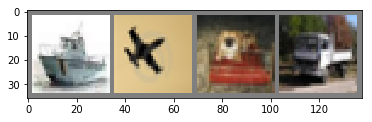

 ship plane   dog truck


In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    
    img = img/2 + 0.5 # unnormalize
    npimg = img.numpy()
#     Permute the axes 
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(" ".join("%5s" % classes[labels[j]] for j in range(len(labels))))

In [55]:
for i in range(len(list(net.parameters()))):
    print(list(net.parameters())[i].size())

torch.Size([64, 3, 7, 7])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([84, 64, 1, 1])
torch.Size([84])
torch.Size([84])
torch.Size([84])
torch.Size([84, 84, 3, 3])
torch.Size([84])
torch.Size([84])
torch.Size([84])
torch.Size([100, 84, 1, 1])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100, 64, 1, 1])
torch.Size([100])
torch.Size([10, 100])
torch.Size([10])


In [56]:
# sanity test
input = Variable(torch.randn(1, 3, 32, 32))
if use_gpu:
    net = net.cuda()
    input = input.cuda()
# print(input)
net.forward(input)

Variable containing:
-0.2883  0.1153 -0.1767 -0.0296  0.0362 -0.3902 -0.7177 -0.1144  0.1577  0.2331
[torch.cuda.FloatTensor of size 1x10 (GPU 0)]

In [57]:
# Optimization
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [58]:
# training

def train():
    for epoch in range(5):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0): # stars from 0
            inputs, labels = data

            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.data[0]

            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')



In [59]:
train()

[1,  2000] loss: 1.941
[1,  4000] loss: 1.762
[1,  6000] loss: 1.650
[1,  8000] loss: 1.556
[1, 10000] loss: 1.490
[1, 12000] loss: 1.424
[2,  2000] loss: 1.400
[2,  4000] loss: 1.343
[2,  6000] loss: 1.313
[2,  8000] loss: 1.277
[2, 10000] loss: 1.251
[2, 12000] loss: 1.238
[3,  2000] loss: 1.198
[3,  4000] loss: 1.175
[3,  6000] loss: 1.179
[3,  8000] loss: 1.141
[3, 10000] loss: 1.113
[3, 12000] loss: 1.117
[4,  2000] loss: 1.077
[4,  4000] loss: 1.083
[4,  6000] loss: 1.072
[4,  8000] loss: 1.064
[4, 10000] loss: 1.036
[4, 12000] loss: 1.037
[5,  2000] loss: 1.000
[5,  4000] loss: 1.010
[5,  6000] loss: 0.992
[5,  8000] loss: 0.986
[5, 10000] loss: 0.961
[5, 12000] loss: 0.960
Finished Training


In [60]:
def accuracy(testloader, net):
    correct = 0
    total = 0

    for data in testloader:
        images, labels = data
        if use_gpu: 
            outputs = net(Variable(images.cuda()))
            labels = labels.cuda()
        else: outputs = net(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    print("Accuracy: ", 100*correct/total, "%")

In [61]:
accuracy(testloader, net)

Accuracy:  66.392 %
